In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import timedelta
import seaborn as sns
import random
plt.style.use('ggplot')

In [13]:
def pd_dttm_import(want_cols):
    '''Parameters: takes in list of column names wanted that will be
    used in pandas .read_csv method
    
    Results: Outputs the indices of the columns names that are date
    values and uses resulting list of indices as parse_dates parameter
    in pandas .read_csv method'''
    dt_ind = []
    for i in want_cols:
        if 'dttm' in i.lower() or 'date' in i.lower():
            dt_ind.append(want_cols.index(i))
    return dt_ind


def to_time_delta(df, time2, time1):
    '''Return series of seconds difference between two datetime columns
    '''
    #create new copy of data frame taking only not null values
    return (df[time2] - df[time1]).apply(lambda x: timedelta.total_seconds(x) if not isinstance(x, pd._libs.tslibs.nattype.NaTType) else None)

In [14]:
#need to ensure this is correct so that it can appropriately parse the date columns
all_columns = ['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Call Date',
       'Watch Date', 'Received DtTm', 'Entry DtTm', 'Dispatch DtTm',
       'Response DtTm', 'On Scene DtTm', 'Transport DtTm', 'Hospital DtTm',
       'Call Final Disposition', 'Available DtTm', 'Address', 'City',
       'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhooods - Analysis Boundaries',
       'Location', 'RowID', 'shape', 'Supervisor Districts',
       'Fire Prevention Districts', 'Current Police Districts',
       'Neighborhoods - Analysis Boundaries', 'Zip Codes',
       'Neighborhoods (old)', 'Police Districts',
       'Civic Center Harm Reduction Project Boundary', 'HSOC Zones',
       'Central Market/Tenderloin Boundary Polygon - Updated', 'Neighborhoods',
       'SF Find Neighborhoods', 'Current Police Districts 2',
       'Current Supervisor Districts']

In [15]:
need_forever_columns = ['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Call Date',
       'Watch Date', 'Received DtTm', 'Entry DtTm', 'Dispatch DtTm',
       'Response DtTm', 'On Scene DtTm', 'Transport DtTm', 'Hospital DtTm',
       'Call Final Disposition', 'Available DtTm', 'Address', 'City',
       'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhooods - Analysis Boundaries',
       'Location', 'RowID', 'shape', 'Supervisor Districts',
       'Fire Prevention Districts', 'Current Police Districts',
       'Neighborhoods - Analysis Boundaries', 'Zip Codes',
       'Neighborhoods (old)', 'Police Districts',
       'Civic Center Harm Reduction Project Boundary', 'HSOC Zones',
       'Central Market/Tenderloin Boundary Polygon - Updated', 'Neighborhoods',
       'SF Find Neighborhoods', 'Current Police Districts 2',
       'Current Supervisor Districts']


In [16]:
df = pd.read_csv('Fire_Department_Calls_for_Service.csv',
                 skiprows = (lambda x: x != 0 and random.random() > 0.2),
                 parse_dates = pd_dttm_import(all_columns))

orig_size = len(df)
print(f'Number of entries: {orig_size}')

/home/christopher/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,20,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of entries: 1091290


### Take a look at the dataframe info

In [17]:
#there are many instances of the call being dispatched to multiple people, no point in looking into that
tot = 0
for i in ['Received DtTm', 'Dispatch DtTm', 'Response DtTm', 'On Scene DtTm']:
    tot += len(df[df[i].isnull()])
    print(f'Number of entries where {i} is NaN: {tot}')
print(f'Percentage of values where time is NaN: {tot/len(df)*100}')


Number of entries where Received DtTm is NaN: 0
Number of entries where Dispatch DtTm is NaN: 0
Number of entries where Response DtTm is NaN: 84135
Number of entries where On Scene DtTm is NaN: 328957
Percentage of values where time is NaN: 30.143866433303707


In [18]:
#drop rows where any of the of-interest time data is NaN
#comfortable dropping this because if any is missing it suggests that the call led to no interaction with EMS
df.dropna(axis = 0, how = 'any', subset = ['Received DtTm', 'Dispatch DtTm', 'Response DtTm', 'On Scene DtTm'], inplace=True)
len(df)

808042

In [19]:
df['call_to_disp'] = to_time_delta(df,'Dispatch DtTm', 'Received DtTm')
df['disp_to_resp'] = to_time_delta(df, 'Response DtTm','Dispatch DtTm')
df['resp_to_scene'] = to_time_delta(df, 'On Scene DtTm','Response DtTm')
#at the moment not interested in time to transport to hospital
#df['time_to_hosp'] = to_time_delta(df, 'Hospital DtTm', 'Transport DtTm')


In [20]:
times = ['call_to_disp','disp_to_resp','resp_to_scene']

In [21]:
#view amount of data that has illogical timestamps (<1)
for col in times:
    num = len(df[df[col] < 0])
    print(f'{col} values < 0: {num} | {(num/len(df))*100:.2f}%')

call_to_disp values < 0: 9 | 0.00%
disp_to_resp values < 0: 54 | 0.01%
resp_to_scene values < 0: 915 | 0.11%


In [22]:
df[df['call_to_disp'] < 0]

,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,...,Civic Center Harm Reduction Project Boundary,HSOC Zones,Central Market/Tenderloin Boundary Polygon - Updated,Neighborhoods,SF Find Neighborhoods,Current Police Districts 2,Current Supervisor Districts,call_to_disp,disp_to_resp,resp_to_scene
9684,203060321,KM04,20125449,Medical Incident,2020-11-01,2020-10-31,2020-11-01 02:01:20,2020-11-01 02:01:20,2020-11-01 01:02:18,2020-11-01 01:02:41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3542.0,23.0,639.0
473611,93050071,E01,9091951,Medical Incident,2009-11-01,2009-10-31,2009-11-01 01:59:02,2009-11-01 01:00:00,2009-11-01 01:00:36,2009-11-01 01:00:52,...,NaN,NaN,NaN,32.0,32.0,1.0,10.0,-3506.0,16.0,100.0
772330,143060322,T06,14108167,Alarms,2014-11-02,2014-11-01,2014-11-02 01:59:55,2014-11-02 02:01:32,2014-11-02 01:03:32,2014-11-02 02:05:36,...,NaN,5.0,NaN,28.0,28.0,3.0,5.0,-3383.0,3724.0,63.0
870805,163110312,T03,16123877,Structure Fire,2016-11-06,2016-11-05,2016-11-06 02:00:20,2016-11-06 02:01:23,2016-11-06 01:01:43,2016-11-06 01:02:55,...,NaN,NaN,1,20.0,20.0,4.0,10.0,-3517.0,72.0,70.0
875068,163110294,55,16123875,Medical Incident,2016-11-06,2016-11-05,2016-11-06 01:48:37,2016-11-06 01:49:53,2016-11-06 01:14:20,2016-11-06 01:14:32,...,NaN,NaN,NaN,19.0,19.0,6.0,3.0,-2057.0,12.0,595.0
882437,163110312,B02,16123877,Structure Fire,2016-11-06,2016-11-05,2016-11-06 02:00:20,2016-11-06 02:01:23,2016-11-06 01:01:43,2016-11-06 01:02:46,...,NaN,NaN,1,20.0,20.0,4.0,10.0,-3517.0,63.0,125.0
885143,163110302,66,16123876,Medical Incident,2016-11-06,2016-11-05,2016-11-06 01:49:54,2016-11-06 01:52:48,2016-11-06 01:16:22,2016-11-06 01:16:33,...,NaN,NaN,NaN,32.0,32.0,1.0,10.0,-2012.0,11.0,522.0
895559,170431047,T04,17018799,Medical Incident,2017-02-12,2017-02-12,2017-02-12 09:37:20,2017-02-12 09:37:32,2017-02-12 08:48:00,2017-02-12 08:48:00,...,NaN,NaN,NaN,108.0,108.0,6.0,3.0,-2960.0,0.0,0.0
1042170,191690263,E17,19072152,Medical Incident,2019-06-18,2019-06-17,2019-06-18 06:15:12,2019-06-18 04:04:00,2019-06-18 04:05:00,2019-06-18 04:07:00,...,NaN,NaN,NaN,86.0,86.0,2.0,9.0,-7812.0,120.0,480.0


In [23]:
#view amount of data that has illogical timestamps (=1)
for col in times:
    num = len(df[df[col] == 0])
    print(f'{col} values = 0: {num} | {(num/len(df))*100:.2f}%')

call_to_disp values = 0: 5518 | 0.68%
disp_to_resp values = 0: 20587 | 2.55%
resp_to_scene values = 0: 13029 | 1.61%


In [24]:
#find all rows where any of the time values are irregular, not interested in calls where no one ends up on scene
tot = df[(df['call_to_disp'] <= 0) | (df['disp_to_resp'] <= 0) | (df['resp_to_scene'] <= 0)]
print(f'Total : {len(tot)}     | Percentage of Data: {len(tot)/len(df)*100:.2f}%')

Total : 29402     | Percentage of Data: 3.64%


In [25]:
#remove the rows with illogical time steps
for col in times:
    df = df[df[col] > 0]

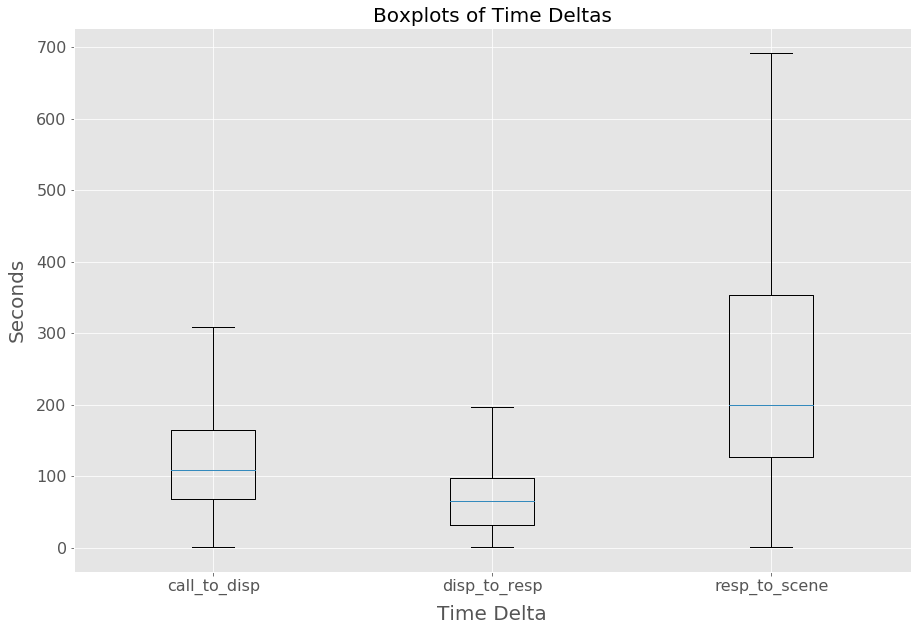

In [26]:
plt.figure(figsize=(15,10))
plt.boxplot((df['call_to_disp'],df['disp_to_resp'],df['resp_to_scene']), labels = times, sym='')
plt.ylabel('Seconds', fontdict = {'fontsize' : 20}, labelpad = 10)
plt.xlabel('Time Delta', fontdict = {'fontsize' : 20}, labelpad = 10)
plt.title('Boxplots of Time Deltas', fontdict = {'fontsize' : 20})
plt.tick_params(labelsize = 16)


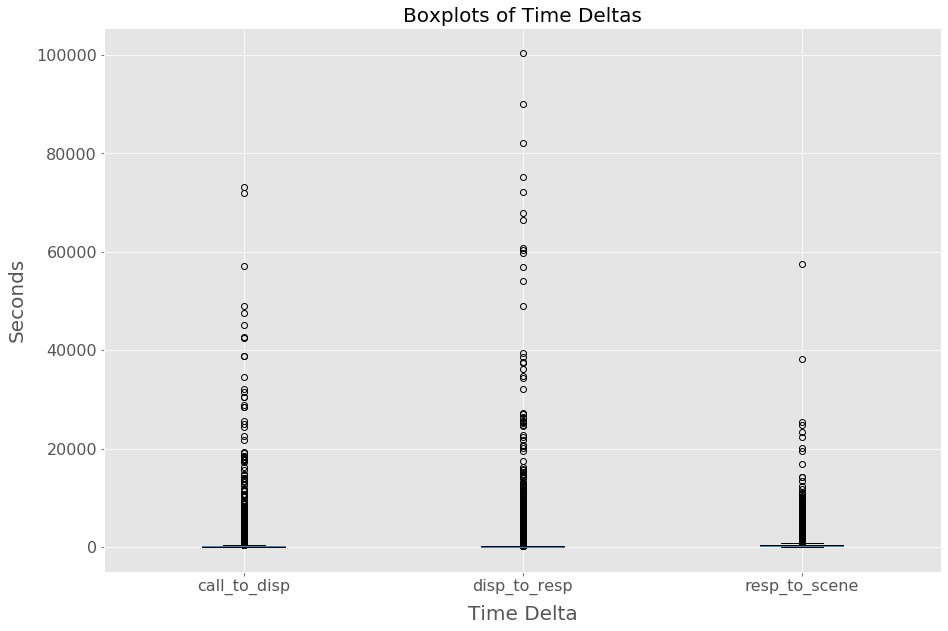

In [27]:
plt.figure(figsize=(15,10))
plt.boxplot((df['call_to_disp'],df['disp_to_resp'],df['resp_to_scene']), labels = times)
plt.ylabel('Seconds', fontdict = {'fontsize' : 20}, labelpad = 10)
plt.xlabel('Time Delta', fontdict = {'fontsize' : 20}, labelpad = 10)
plt.title('Boxplots of Time Deltas', fontdict = {'fontsize' : 20})
plt.tick_params(labelsize = 16)

In [28]:
#anything over 1 hour I am going to take as a mistake and cap at 1 hour

In [29]:
for i in times:
    df[i] = df[i].apply(lambda x: x if x < 3600 else 3600)

In [30]:
#check number of values over 2.5 times standard deviation
#given how many time stamps errors are made, that makes me more confident in removing the outliers, rather than trusting them
#also, what good is predicting that an ambulence will take 3 hours? There's no way the data available indicates the cause of such and annomaly

In [31]:
def data_above_mean(df, cols, std_mult):
    '''Takes in dataframe, list of column names in dataframe, and number of standard deviations above mean
    of interest and outputs the amount of the data in each column that is above that limit'''
    for col in cols:
        stan = df[col].std()
        mn = df[col].mean()
        print(f'{col:13} percent of values over {std_mult}x std above mean ({std_mult*stan+mn:.0f}): % {(len(df[df[col] > std_mult*stan+mn])/len(df))*100:.3f}')

In [32]:
data_above_mean(df, times, 2.5)

call_to_disp  percent of values over 2.5x std above mean (542): % 1.476
disp_to_resp  percent of values over 2.5x std above mean (411): % 1.212
resp_to_scene percent of values over 2.5x std above mean (1027): % 3.092


In [33]:
#however, the 2.5x outlier includes far to much data for resp_to_scene and time_to_hosp

In [34]:
data_above_mean(df,times,3)

call_to_disp  percent of values over 3x std above mean (623): % 1.148
disp_to_resp  percent of values over 3x std above mean (477): % 1.028
resp_to_scene percent of values over 3x std above mean (1173): % 2.063


#### Alternative: Remove all outliers - but going to leave in for now

In [35]:
#can drop earlier DtTm columns except Received DtTm - going to do some feature engineering on that
df.drop(labels=['Entry DtTm','Dispatch DtTm','Response DtTm','On Scene DtTm','Transport DtTm',
               'Hospital DtTm','Available DtTm'], axis=1, inplace = True)

In [36]:
#since keeping received dttm, can drop call date
df.drop(labels = 'Call Date', axis=1, inplace = True)

# Worth Exploring - but not to include in model

In [37]:
df['Battalion'].value_counts()

B02    132441
B03    129934
B01     83671
B04     77236
B10     66268
B08     66164
B09     61125
B05     59120
B06     57775
B07     41406
B99      3499
3E          1
Name: Battalion, dtype: int64

In [38]:
df['Station Area'].value_counts()

1.0     84382
3.0     63240
36.0    39001
7.0     34756
6.0     23974
        ...  
53         30
47          2
53          1
E2          1
94          1
Name: Station Area, Length: 99, dtype: int64

In [39]:
df['Original Priority'].value_counts()

3    565008
2    131132
1     27061
E     25395
A     13999
B      7801
C      4476
I       589
T         6
Name: Original Priority, dtype: int64

In [40]:
df['Priority'].value_counts()

3    567498
2    150090
E     32152
1     28118
A       512
B       240
C        20
I         8
T         1
Name: Priority, dtype: int64

In [41]:
df['Final Priority'].value_counts()

3    599680
2    178960
Name: Final Priority, dtype: int64

In [42]:
df['Fire Prevention District'].value_counts()

2       147795
3       113959
1        85044
4        70990
10       64337
9        63518
6        60778
8        60646
5        57175
7        47615
None      5397
10.0       197
7.0        196
9.0        164
8.0        155
6.0        147
3.0        143
2.0        142
5.0        103
1.0         72
4.0         67
Name: Fire Prevention District, dtype: int64

In [43]:
df['Location'].value_counts()

(37.777624238929, -122.39998111124)         3035
(37.786117211838, -122.419854245692)        2620
(37.78114586126, -122.409026046516)         1978
(37.783386237938, -122.409853729941)        1922
(37.784091036176, -122.411784369455)        1756
                                            ... 
(37.759155421432, -122.389436013166)           1
(37.802959913423, -122.423113037909)           1
(37.775843378924, -122.495720780873)           1
(37.830454788392, -122.376294510611)           1
(37.80805009693562, -122.40987728293071)       1
Name: Location, Length: 56013, dtype: int64

In [44]:
df['RowID']

0            202732150-66
1          203441547-KM02
2            203440174-61
3           203440158-T01
4           202620171-E35
                ...      
1091284     210043264-E11
1091285     210042466-E44
1091286     210042008-RC1
1091287     210041455-E10
1091289     210040687-E06
Name: RowID, Length: 778640, dtype: object

In [45]:
#various districts

In [46]:
df['Neighborhoods - Analysis Boundaries'].value_counts()

36.0    98099
20.0    73352
34.0    71351
8.0     49871
1.0     41634
35.0    31880
39.0    29614
21.0    25093
29.0    20896
9.0     19398
5.0     18809
41.0    17679
30.0    16556
6.0     16060
23.0    16051
7.0     15751
2.0     14561
13.0    14363
14.0    12555
32.0    12045
3.0     11950
16.0    11824
28.0    11698
24.0    11243
11.0    10534
40.0    10084
26.0    10065
18.0     9745
4.0      8865
22.0     8435
25.0     7220
31.0     7208
15.0     7207
38.0     4890
12.0     4299
37.0     4190
10.0     3908
27.0     2182
33.0     1278
19.0      845
17.0      646
Name: Neighborhoods - Analysis Boundaries, dtype: int64

In [47]:
df['SF Find Neighborhoods'].value_counts()

32.0    84590
20.0    70186
53.0    49417
39.0    21398
50.0    20397
        ...  
63.0      564
69.0      398
70.0      266
7.0       228
73.0      211
Name: SF Find Neighborhoods, Length: 117, dtype: int64

In [48]:
df['Neighborhoods'].value_counts()

32.0    84590
20.0    70186
53.0    49417
39.0    21398
50.0    20397
        ...  
63.0      564
69.0      398
70.0      266
7.0       228
73.0      211
Name: Neighborhoods, Length: 117, dtype: int64

In [49]:
df['Central Market/Tenderloin Boundary Polygon - Updated'].value_counts()

1    127748
Name: Central Market/Tenderloin Boundary Polygon - Updated, dtype: int64

In [50]:
df.columns

Index(['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Watch Date',
       'Received DtTm', 'Call Final Disposition', 'Address', 'City',
       'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhooods - Analysis Boundaries',
       'Location', 'RowID', 'shape', 'Supervisor Districts',
       'Fire Prevention Districts', 'Current Police Districts',
       'Neighborhoods - Analysis Boundaries', 'Zip Codes',
       'Neighborhoods (old)', 'Police Districts',
       'Civic Center Harm Reduction Project Boundary', 'HSOC Zones',
       'Central Market/Tenderloin Boundary Polygon - Updated', 'Neighborhoods',
       'SF Find Neighborhoods', 'Current Police Districts 2',
       'Current Supervisor Districts', 'call_to_disp', 'disp_to_resp',
  

In [51]:
#can drop this also

In [52]:
df['Address'].value_counts()
#can use street names

0 Block of 6TH ST           4583
800 Block of MARKET ST      3922
300 Block of EDDY ST        3370
500 Block of 5TH ST         3337
200 Block of EDDY ST        3111
                            ... 
26TH AV/RIVERA ST              1
LAKE ST/8TH AV                 1
100 Block of DEL SUR AVE       1
0 Block of RAYCLIFF TR         1
1300 Block of 15TH AV          1
Name: Address, Length: 25068, dtype: int64

In [53]:
df['shape'].value_counts()
#looking into these coordinates, first two line up with SF homeless shelters

POINT (-122.39998111124 37.777624238929)         3035
POINT (-122.419854245692 37.786117211838)        2620
POINT (-122.409026046516 37.78114586126)         1978
POINT (-122.409853729941 37.783386237938)        1922
POINT (-122.411784369455 37.784091036176)        1756
                                                 ... 
POINT (-122.442710901431 37.744284929543)           1
POINT (-122.433129679661 37.715423481296)           1
POINT (-122.47018490461 37.765659445623)            1
POINT (-122.49388318547112 37.75627814672951)       1
POINT (-122.4344689000052 37.79620822379951)        1
Name: shape, Length: 50616, dtype: int64

## Checking to see if features are useable
- For categorical, make sure there are not too many values to dummify, and search for outliers

In [54]:
df.columns

Index(['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Watch Date',
       'Received DtTm', 'Call Final Disposition', 'Address', 'City',
       'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhooods - Analysis Boundaries',
       'Location', 'RowID', 'shape', 'Supervisor Districts',
       'Fire Prevention Districts', 'Current Police Districts',
       'Neighborhoods - Analysis Boundaries', 'Zip Codes',
       'Neighborhoods (old)', 'Police Districts',
       'Civic Center Harm Reduction Project Boundary', 'HSOC Zones',
       'Central Market/Tenderloin Boundary Polygon - Updated', 'Neighborhoods',
       'SF Find Neighborhoods', 'Current Police Districts 2',
       'Current Supervisor Districts', 'call_to_disp', 'disp_to_resp',
  

In [55]:
'''Can remove columns that have information I am not interested in,
Unit ID : Too many to use in a model, but can look into it
Incident Number: Not much info in there except tracking if Units were on same call - could feature engineer into ambulances already responded
Watch Date: Redundant, don't need

remove location data besides neighborhood - Can try and do more with potential traffic hazzards later, but will generally be captured by neighborhood
Address: Can use feature to note places where calls are happening really frequently,
City,
Zipcode of Incident: redundant with neighborhood,
Battalion,
Station Area,
Box,
Fire Prevention District,
Supervisor District (not sure what this is so won't use it),
Location (can try to domore with this column based on congestion in that area)

Remove also:
RowID: don't need it,
shape, Supervisor Districts, Fire Prevention Districts,
Current Police Districts, Neighborhoods (both of them), Zip Codes, Police Districts, Neighborhoods, SF Find Neighborhoods
Current Police Districts 2, Current Supervisor Districts'''

"Can remove columns that have information I am not interested in,\nUnit ID : Too many to use in a model, but can look into it\nIncident Number: Not much info in there except tracking if Units were on same call - could feature engineer into ambulances already responded\nWatch Date: Redundant, don't need\n\nremove location data besides neighborhood - Can try and do more with potential traffic hazzards later, but will generally be captured by neighborhood\nAddress: Can use feature to note places where calls are happening really frequently,\nCity,\nZipcode of Incident: redundant with neighborhood,\nBattalion,\nStation Area,\nBox,\nFire Prevention District,\nSupervisor District (not sure what this is so won't use it),\nLocation (can try to domore with this column based on congestion in that area)\n\nRemove also:\nRowID: don't need it,\nshape, Supervisor Districts, Fire Prevention Districts,\nCurrent Police Districts, Neighborhoods (both of them), Zip Codes, Police Districts, Neighborhoods, 

#### Alternative: Keep Incident Number in there to see any correlation

In [56]:
df.columns

Index(['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Watch Date',
       'Received DtTm', 'Call Final Disposition', 'Address', 'City',
       'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhooods - Analysis Boundaries',
       'Location', 'RowID', 'shape', 'Supervisor Districts',
       'Fire Prevention Districts', 'Current Police Districts',
       'Neighborhoods - Analysis Boundaries', 'Zip Codes',
       'Neighborhoods (old)', 'Police Districts',
       'Civic Center Harm Reduction Project Boundary', 'HSOC Zones',
       'Central Market/Tenderloin Boundary Polygon - Updated', 'Neighborhoods',
       'SF Find Neighborhoods', 'Current Police Districts 2',
       'Current Supervisor Districts', 'call_to_disp', 'disp_to_resp',
  

In [57]:
remove_lst = ['Unit ID','Incident Number','Watch Date','Call Final Disposition','Address','City',
              'Zipcode of Incident', 'Battalion','Station Area','Box','Fire Prevention District',
              'Supervisor District','Location','RowID','shape','Supervisor Districts','Fire Prevention Districts',
              'Current Police Districts','Neighborhoods - Analysis Boundaries','Zip Codes','Neighborhoods (old)',
              'Police Districts','Neighborhoods','SF Find Neighborhoods','Current Police Districts 2',
              'Current Supervisor Districts']

## Pipeline: find indexes at points not in this list to include ^

In [58]:
df.drop(labels=remove_lst, axis=1, inplace=True)

## Investigate remaining features

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778640 entries, 0 to 1091289
Data columns (total 18 columns):
Call Number                                             778640 non-null int64
Call Type                                               778640 non-null object
Received DtTm                                           778640 non-null datetime64[ns]
Original Priority                                       775467 non-null object
Priority                                                778639 non-null object
Final Priority                                          778640 non-null int64
ALS Unit                                                778640 non-null bool
Call Type Group                                         388895 non-null object
Number of Alarms                                        778640 non-null int64
Unit Type                                               778640 non-null object
Unit sequence in call dispatch                          778633 non-null float64
Neighborhooods 

#### Remove things with a lot of null values

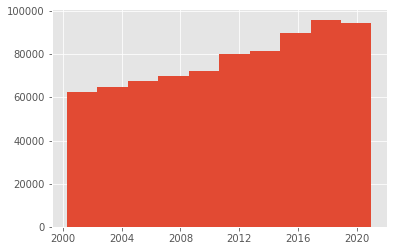

In [60]:
#going to be checking by dates, check overall trend of calls
df['Received DtTm'].hist()

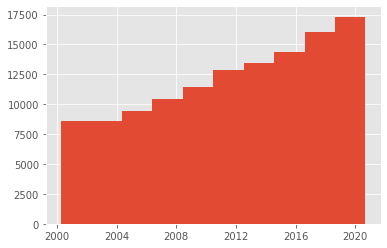

In [61]:
#I believe the last 3 columns are new ones, and might leave them in if I decide to run regression on only recent events
df['Received DtTm'][~df['Civic Center Harm Reduction Project Boundary'].isnull()].hist()

In [62]:
#seems like there has been a relative increase in including column recently, but is still too sparse to bother using
#Verdict: Can remove Civic Center Harm Reduction Project Boundary

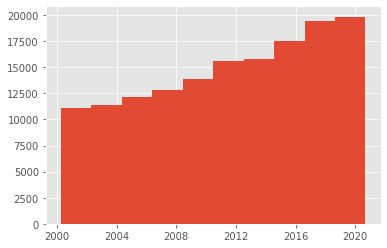

In [63]:
#I believe the last 3 columns are new ones, and might leave them in if I decide to run regression on only recent events
df['Received DtTm'][~df['HSOC Zones'].isnull()].hist()

In [64]:
#seems like there has been a relative increase in including column recently, but is still too sparse to bother using
#Verdict: Can remove HSOC Zones

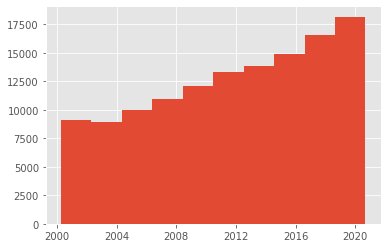

In [65]:
#I believe the last 3 columns are new ones, and might leave them in if I decide to run regression on only recent events
df['Received DtTm'][~df['Central Market/Tenderloin Boundary Polygon - Updated'].isnull()].hist()

In [66]:
#seems like there has been a relative increase in including column recently, but is still too sparse to bother using
#Verdict: Can remove Central Market/Tenderloin Boundary Polygon - Updated

In [67]:
to_rmv = ['Civic Center Harm Reduction Project Boundary',
          'HSOC Zones',
          'Central Market/Tenderloin Boundary Polygon - Updated']

In [68]:
df.drop(labels=to_rmv, axis=1, inplace=True)

### Investigate 'Unit sequence in call dispatch' column

In [69]:
#I believe this is how many other current calls were being actively dispatched at the same time

In [70]:
df['Unit sequence in call dispatch'].unique()[:None]

array([ 2.,  1.,  3.,  5.,  8.,  6.,  7.,  9., 10.,  4., 13., 12., 11.,
       17., 38., 31., 62., 42., 22., 14., 24., 16., 15., 23., 54., 26.,
       34., 39., 19., 40., 84., 29., 20., 43., 18., 72., 21., 28., 45.,
       48., 33., 30., 27., 47., 32., 25., 41., 44., 55., 37., 36., 46.,
       35., 51., 49., 56., 50., 52., 66., 60., 59., 57., 58., 65., nan])

In [71]:
def plot_bar_graph(df, col_name, low_limit = None, high_limit = None, font_size = 10, tick_size = 10, rot = 'vertical'):
    '''Takes in dataframe, column, and the number of unique values you would like to see in descending order
    based on value counts and outputs a bar graph'''

    
    plt.figure(figsize =(20,15))  
    labels_ = df[col_name].value_counts().index[low_limit:high_limit]
    if type(df[col_name][0]) == str:
        plt.xticks(ticks=range(len(labels_)), labels = labels_, rotation=rot)
    else:
        plt.xticks(labels_)
    plt.tick_params(labelsize=tick_size)
    plt.bar(x = df[col_name].value_counts().index[low_limit:high_limit], height = df[col_name].value_counts().values[low_limit:high_limit])
    plt.title(f'Counts of {col_name}', fontdict = {'fontsize' : font_size})
    plt.xlabel(f'{col_name}', fontdict = {'fontsize' : font_size})
    plt.ylabel('Counts', fontdict = {'fontsize' : font_size})
       

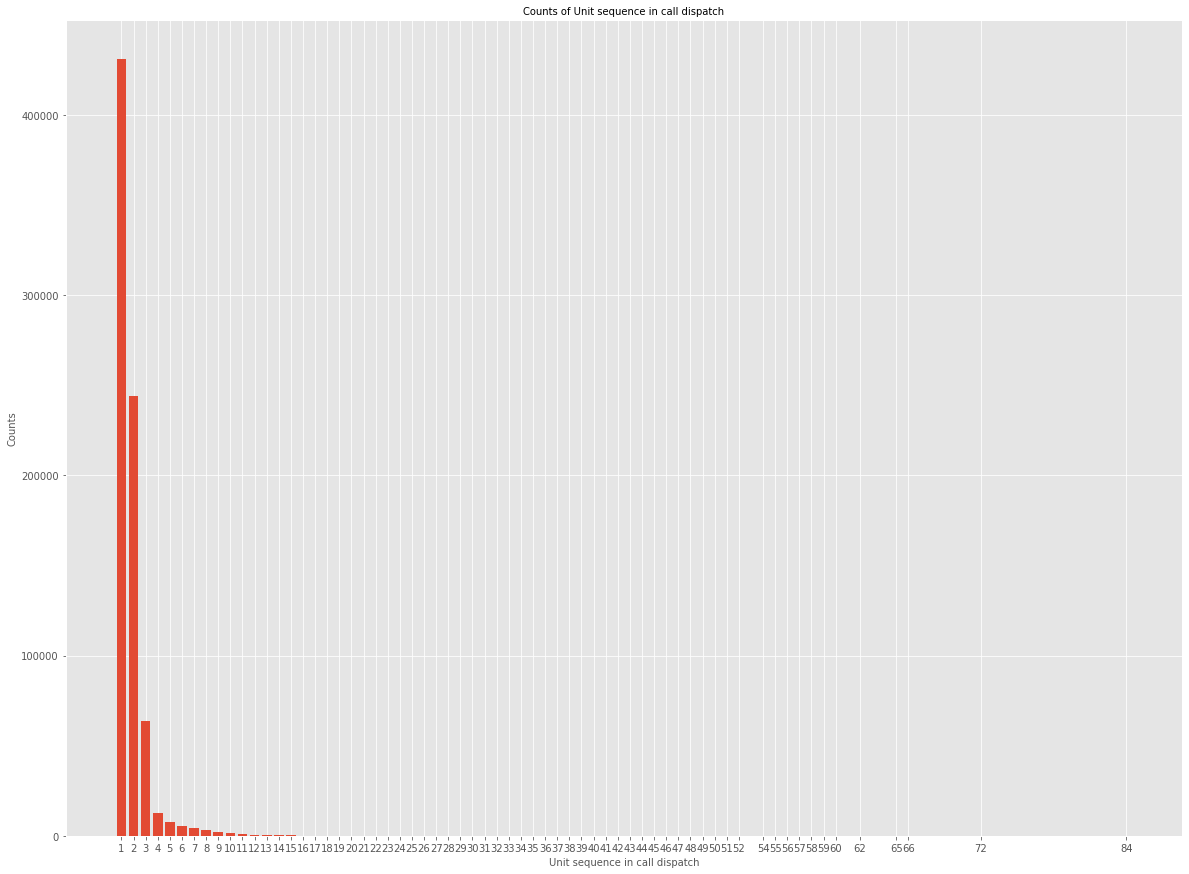

In [72]:
plot_bar_graph(df, 'Unit sequence in call dispatch')

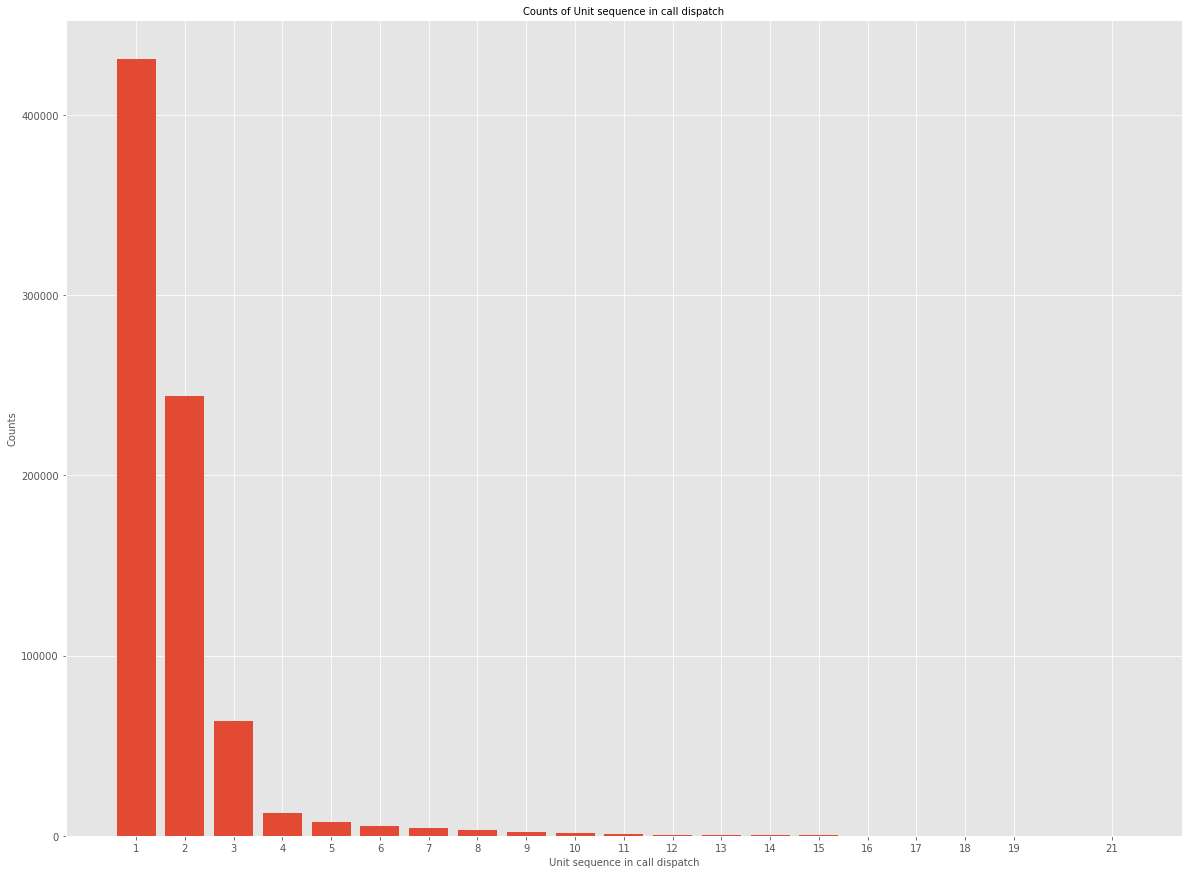

In [73]:
#Seems to end significant amounts around 20, will investigate dates of days with unusually high values
plot_bar_graph(df, 'Unit sequence in call dispatch', high_limit=20)

KeyboardInterrupt: 

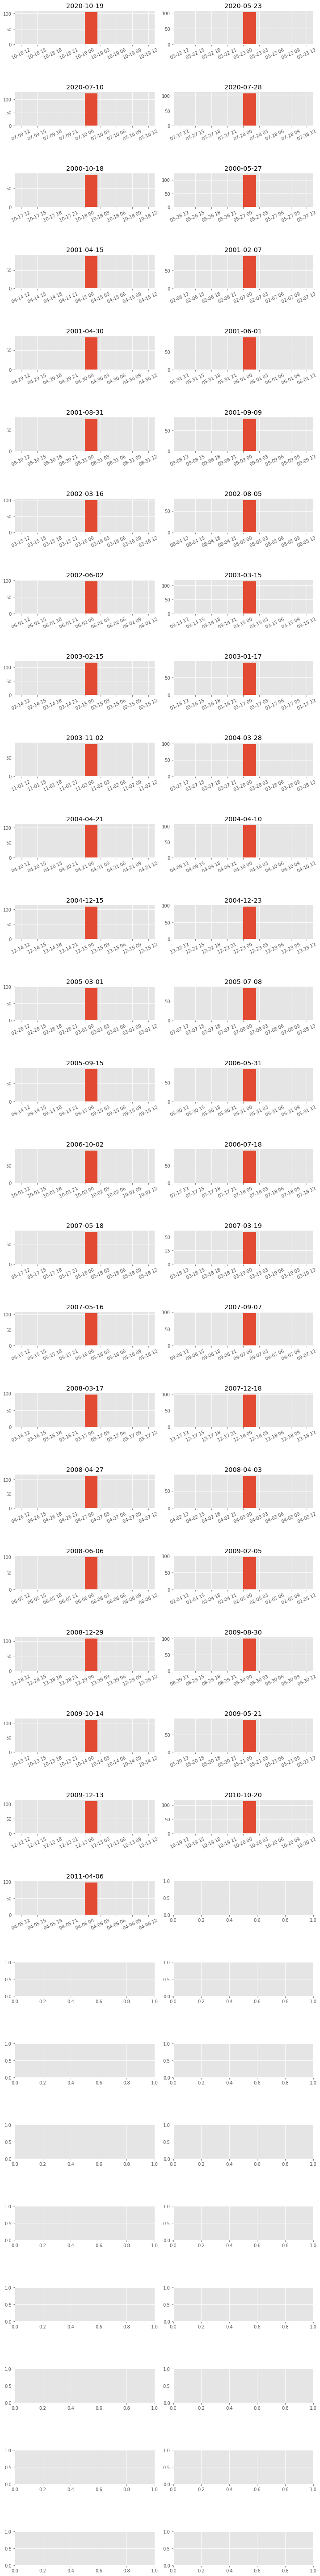

In [74]:
#take a look at the predominant call type from that day
fig, axs = plt.subplots(32,2, figsize = (10,80))
fig.tight_layout()
plt.subplots_adjust(hspace=1.4)
for (i, j) in zip(df['Received DtTm'].apply(lambda x: x.date())[df['Unit sequence in call dispatch'] > 30].unique(), axs.flatten()):
    df['Received DtTm'].apply(lambda x: x.date())[df['Received DtTm'].apply(lambda x: x.date()) == i].hist(xrot = 25, ax = j)
    j.set_title(str(i))


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778640 entries, 0 to 1091289
Data columns (total 14 columns):
Call Type                               778640 non-null object
Received DtTm                           778640 non-null datetime64[ns]
Original Priority                       775467 non-null object
Priority                                778639 non-null object
Final Priority                          778640 non-null int64
ALS Unit                                778640 non-null bool
Call Type Group                         388895 non-null object
Number of Alarms                        778640 non-null int64
Unit Type                               778640 non-null object
Unit sequence in call dispatch          778633 non-null float64
Neighborhooods - Analysis Boundaries    778640 non-null object
call_to_disp                            778640 non-null float64
disp_to_resp                            778640 non-null float64
resp_to_scene                           778640 non-null float6

### Investigate Call Type

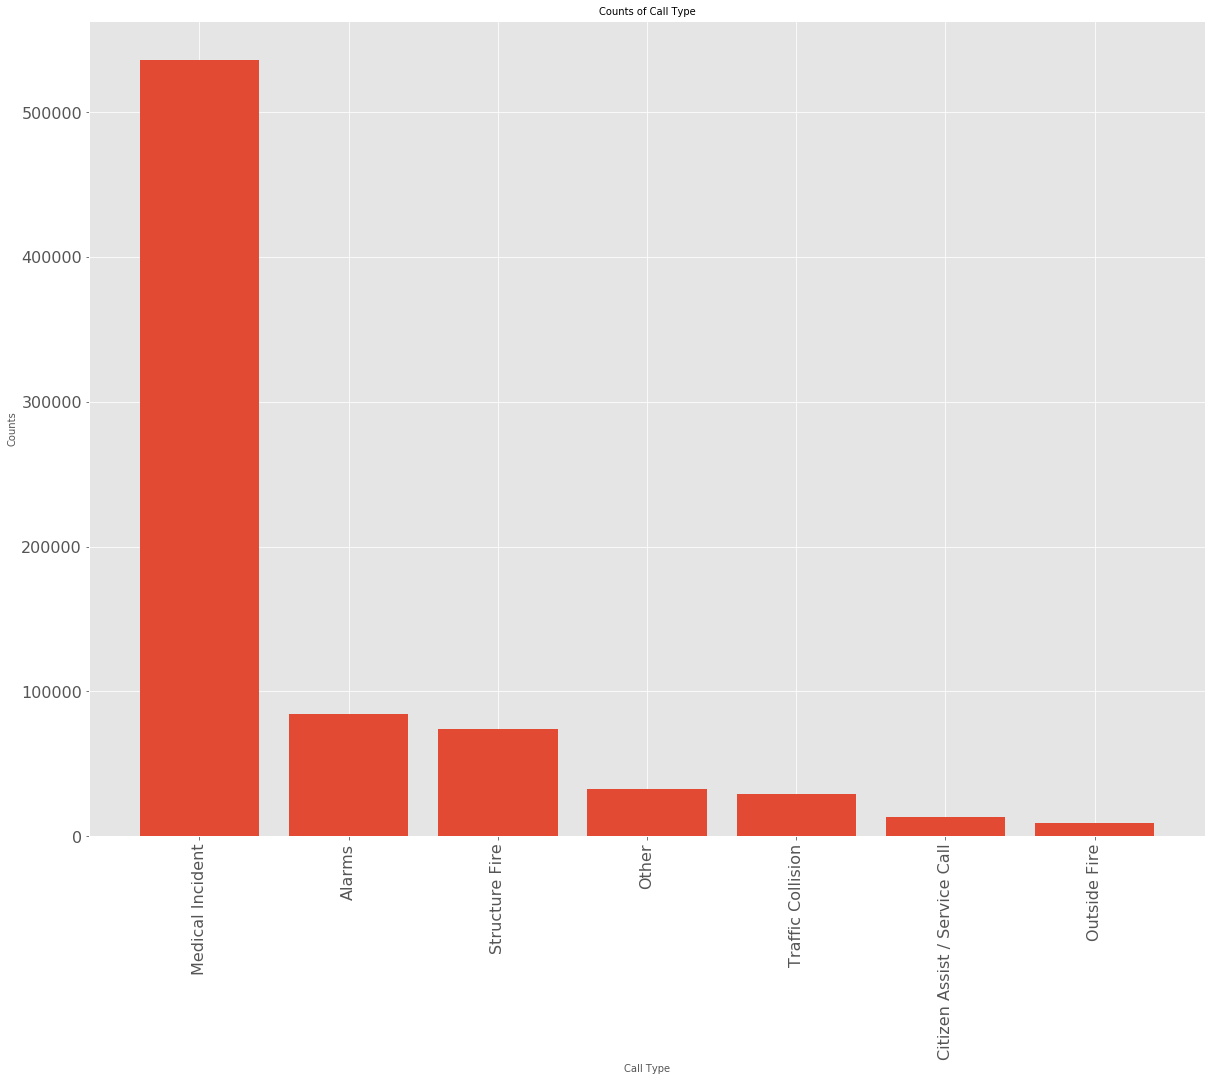

In [83]:
plot_bar_graph(df, 'Call Type', tick_size=16)

Text(0.5, 1.0, 'Call To Dispatch')

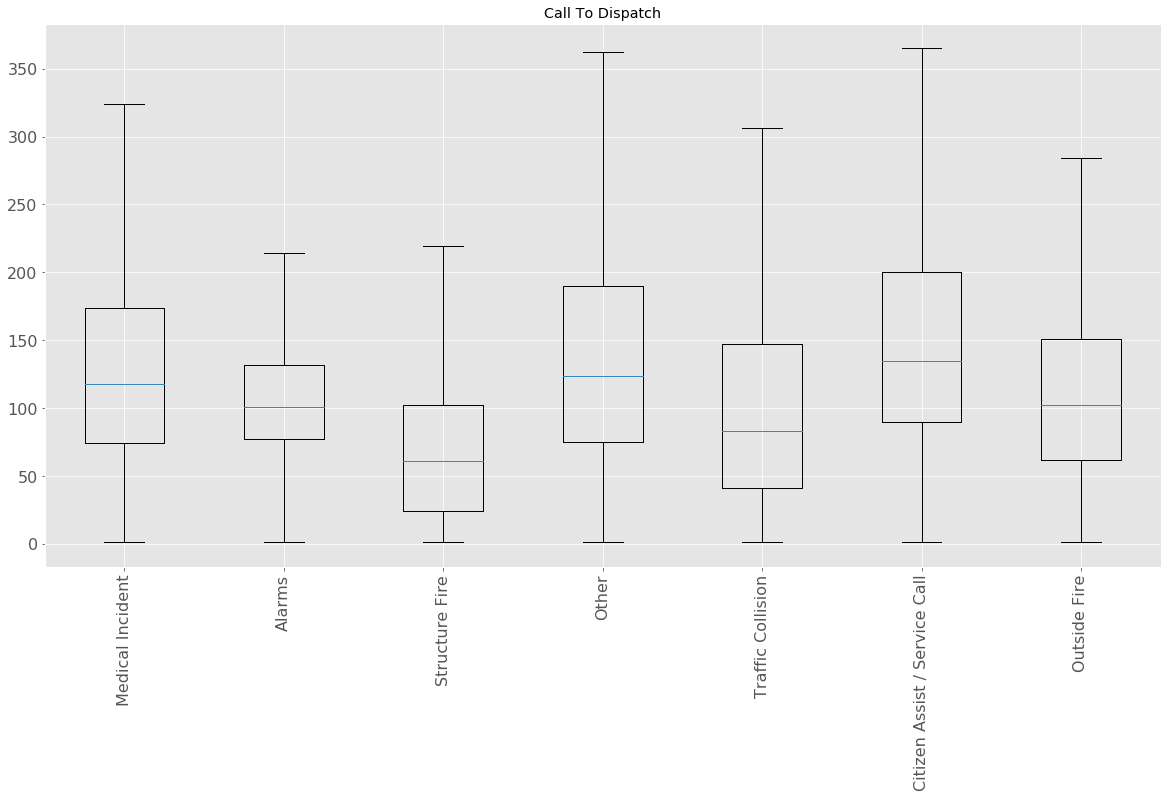

In [84]:
#check if any of the existing Call Types have really distinct distributions of time - matching order doesn't matter
df_searchable = df.set_index('Call Type')['call_to_disp']
groups = df['Call Type'].value_counts().index
all_vals = []

for i in groups:
    all_vals.append(df_searchable[df_searchable.index == i].values)
    
plt.figure(figsize =(20,10))
plt.boxplot(all_vals, sym='', labels=groups)
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=16)
plt.title('Call To Dispatch')



In [85]:
#potentially distinct ones: Watercraft in distress, High Angle Rescue, Train / Rail Incident

Text(0.5, 1.0, 'Dispatch To Response Time')

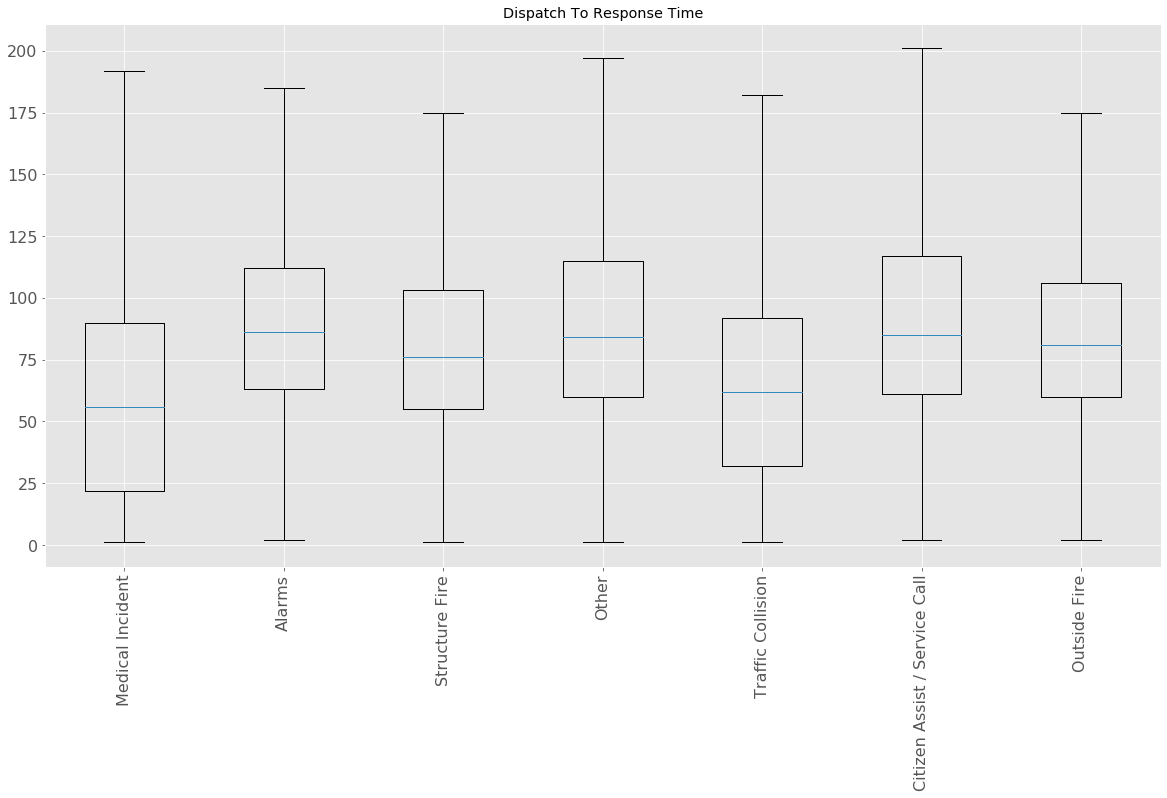

In [86]:
#check if any of the existing Call Types have really distinct distributions of time - matching order doesn't matter
df_searchable = df.set_index('Call Type')['disp_to_resp']
groups = df['Call Type'].value_counts().index
all_vals = []

for i in groups:
    all_vals.append(df_searchable[df_searchable.index == i].values)
    
plt.figure(figsize =(20,10))
plt.boxplot(all_vals, sym='', labels=groups)
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=16)
plt.title('Dispatch To Response Time')



In [87]:
#potentially distinct ones: None

Text(0.5, 1.0, 'Response to On Scene Time')

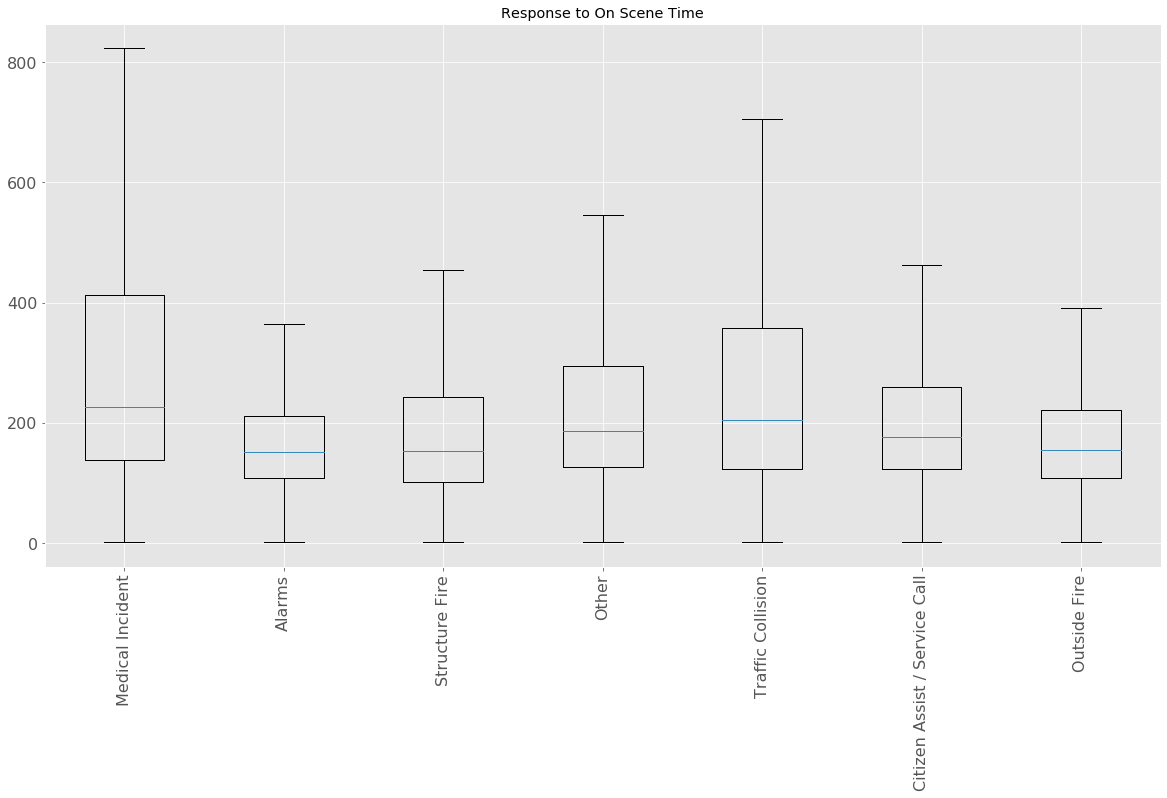

In [88]:
#check if any of the existing Call Types have really distinct distributions of time - matching order doesn't matter
df_searchable = df.set_index('Call Type')['resp_to_scene']
groups = df['Call Type'].value_counts().index
all_vals = []

for i in groups:
    all_vals.append(df_searchable[df_searchable.index == i].values)
    
plt.figure(figsize =(20,10))
plt.boxplot(all_vals, sym='', labels=groups)
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=16)
plt.title('Response to On Scene Time')



In [89]:
#potentially distinct ones: Administrative, Aircraft Emergecy, High Angle Rescue, Water Rescue,
#Mutual Aid / Assist Outside Agency, Train / Rail Fire


In [90]:
#can delete rows with "Administrative", not interested in them
df  = df[df['Call Type'] != 'Administrative']

In [91]:
#don't congregate into other
no_congr = ['Watercraft in Distress','High Angle Rescue','Train / Rail Incident',
           'Aircraft Emergency','Water Rescue','Mutual Aid / Assist Outside Agency','Train / Rail Fire']

In [92]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

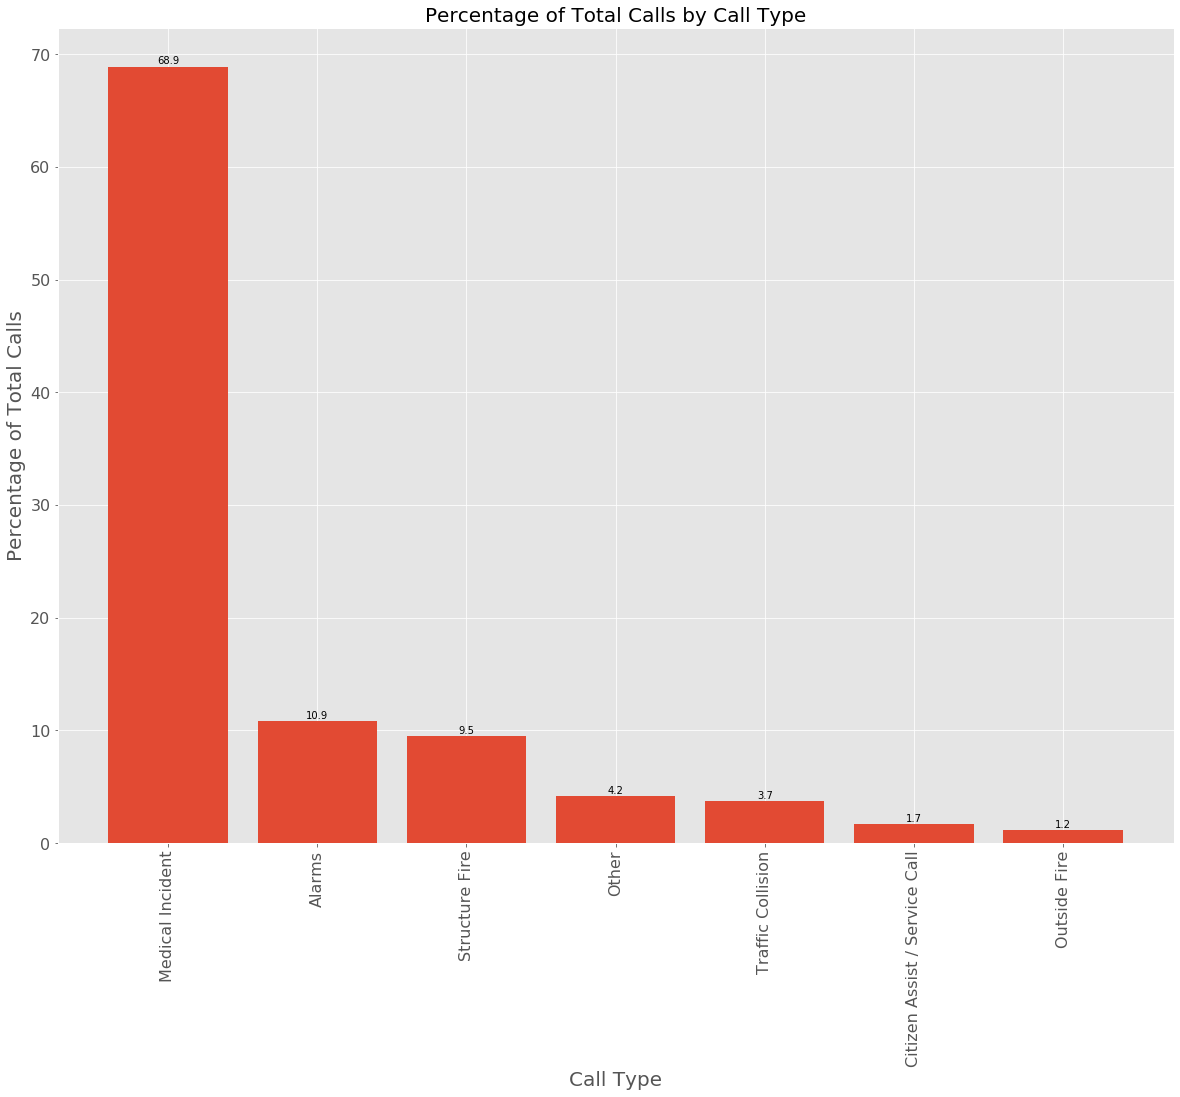

In [93]:
#take a look at what percentage of total cases cutoff to take

#set figure size
plt.figure(figsize =(20,15))  
#set labels with consistent order
labels_ = df['Call Type'].value_counts().index
#set xticks to appropriate location and with appropriate ordered labels
plt.xticks(ticks=range(len(labels_)), labels = labels_, rotation='vertical')
#plot each call type as the percentage of total calls
s = plt.bar(x = df['Call Type'].value_counts().index, height = (df['Call Type'].value_counts().values/len(df))*100)
plt.tick_params(labelsize=16)
plt.ylabel('Percentage of Total Calls', fontdict = {'fontsize' : 20,})
plt.xlabel('Call Type',fontdict = {'fontsize' : 20})
plt.title('Percentage of Total Calls by Call Type',fontdict = {'fontsize' : 20})

#function to show values
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height+.05,
                f'{height:.1f}',
                ha='center', va='bottom')
autolabel(s)


In [94]:
#lets combine everything that has <= 1% of
keep = list(df['Call Type'].value_counts().index[df['Call Type'].value_counts().values/len(df) > 0.01])

In [95]:
# add on other keep
keep += no_congr
print(keep)

['Medical Incident', 'Alarms', 'Structure Fire', 'Other', 'Traffic Collision', 'Citizen Assist / Service Call', 'Outside Fire', 'Watercraft in Distress', 'High Angle Rescue', 'Train / Rail Incident', 'Aircraft Emergency', 'Water Rescue', 'Mutual Aid / Assist Outside Agency', 'Train / Rail Fire']


In [96]:
#convert anything call type not in list to 'Other'
df['Call Type'] = df['Call Type'].apply(lambda x: x if x in keep else 'Other')

### Investigate Original Priority

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778640 entries, 0 to 1091289
Data columns (total 14 columns):
Call Type                               778640 non-null object
Received DtTm                           778640 non-null datetime64[ns]
Original Priority                       775467 non-null object
Priority                                778639 non-null object
Final Priority                          778640 non-null int64
ALS Unit                                778640 non-null bool
Call Type Group                         388895 non-null object
Number of Alarms                        778640 non-null int64
Unit Type                               778640 non-null object
Unit sequence in call dispatch          778633 non-null float64
Neighborhooods - Analysis Boundaries    778640 non-null object
call_to_disp                            778640 non-null float64
disp_to_resp                            778640 non-null float64
resp_to_scene                           778640 non-null float6

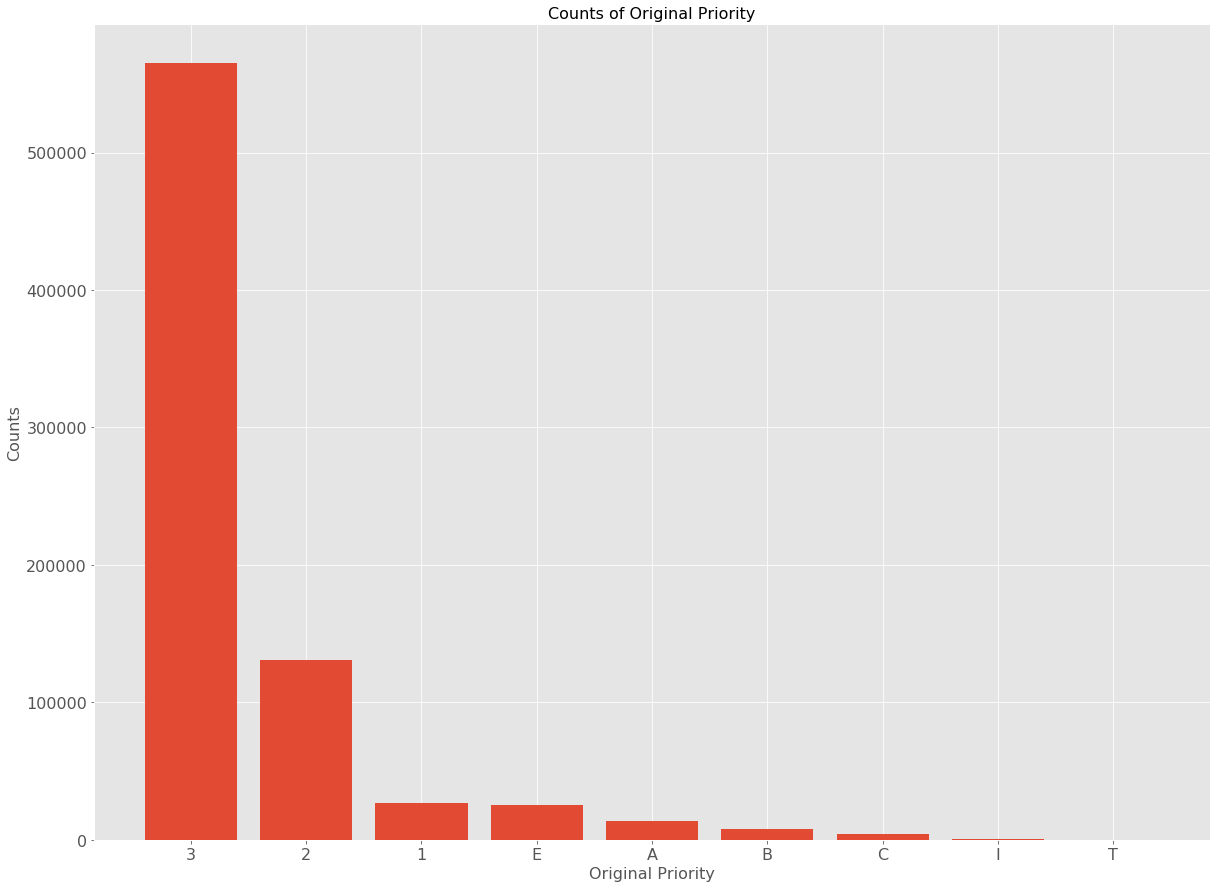

In [98]:
plot_bar_graph(df, 'Original Priority', tick_size = 16, font_size = 16, rot='horizontal')

In [99]:
#can remove samples with I or T, will not bother with them
df = df[~df['Original Priority'].isin(['I','T'])]

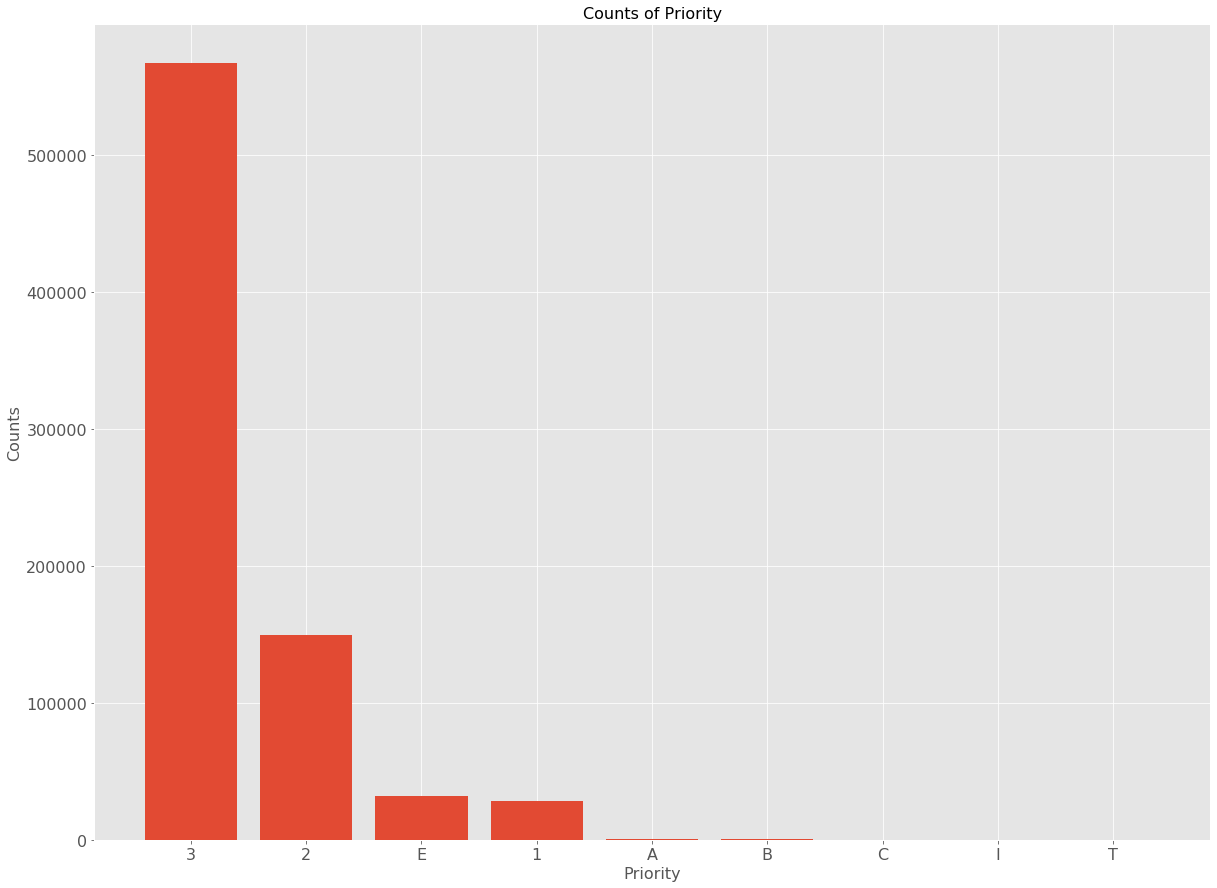

In [100]:
plot_bar_graph(df, 'Priority', tick_size = 16, font_size = 16, rot='horizontal')

In [101]:
#huge correlation: going to remove 'Priority' Entirely
df.drop(labels='Priority', axis=1, inplace=True)

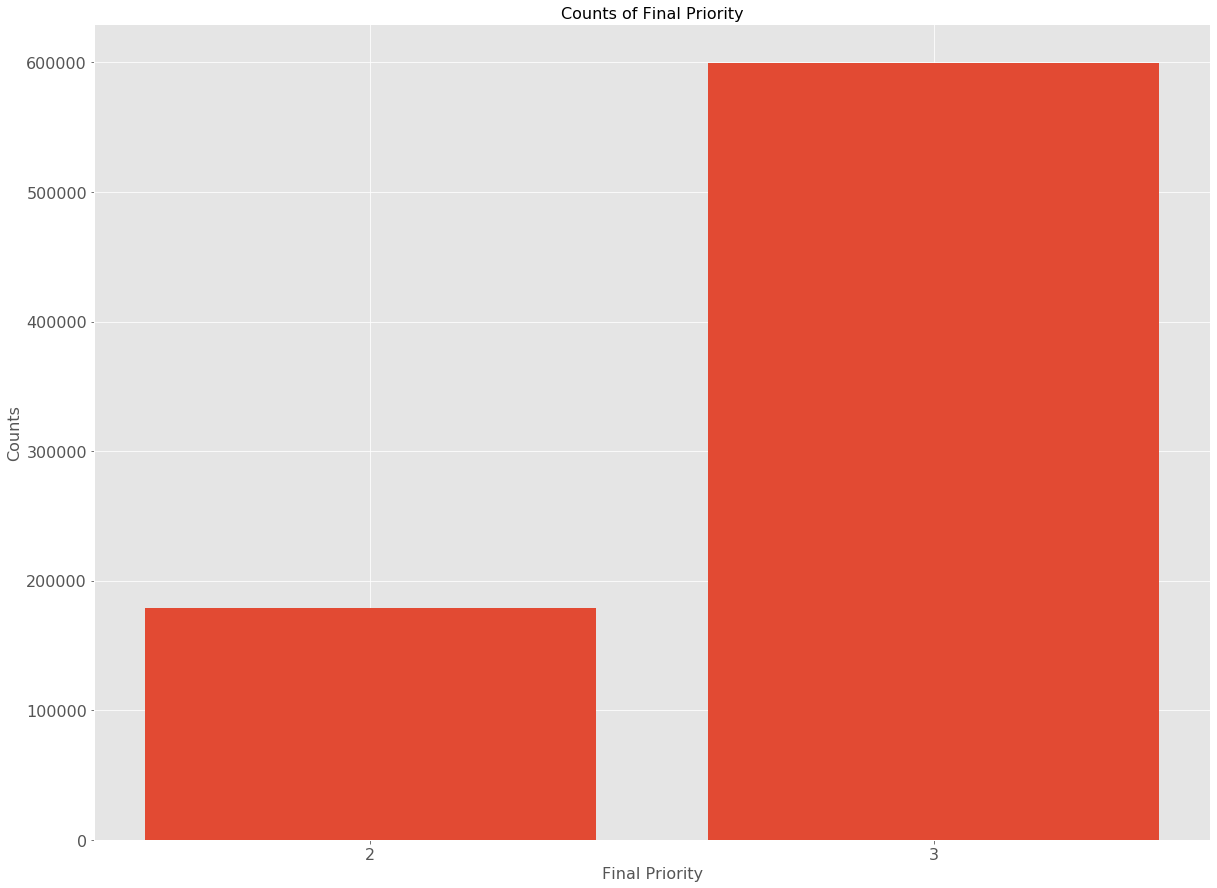

In [102]:
plot_bar_graph(df, 'Final Priority', tick_size = 16, font_size = 16, rot='horizontal')

In [103]:
#don't actually plan on using this so can remove, but good to see final priority distribution
df.drop(labels='Final Priority', axis=1, inplace=True)

In [104]:
df.columns

Index(['Call Type', 'Received DtTm', 'Original Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch',
       'Neighborhooods - Analysis Boundaries', 'call_to_disp', 'disp_to_resp',
       'resp_to_scene'],
      dtype='object')

### Investigate ALS Unit

In [105]:
df['ALS Unit'].value_counts()

True     508686
False    269359
Name: ALS Unit, dtype: int64

In [106]:
sum(df['ALS Unit'].isnull())

0

In [107]:
#good to use - will convert later

### Investigate Number of Alarms

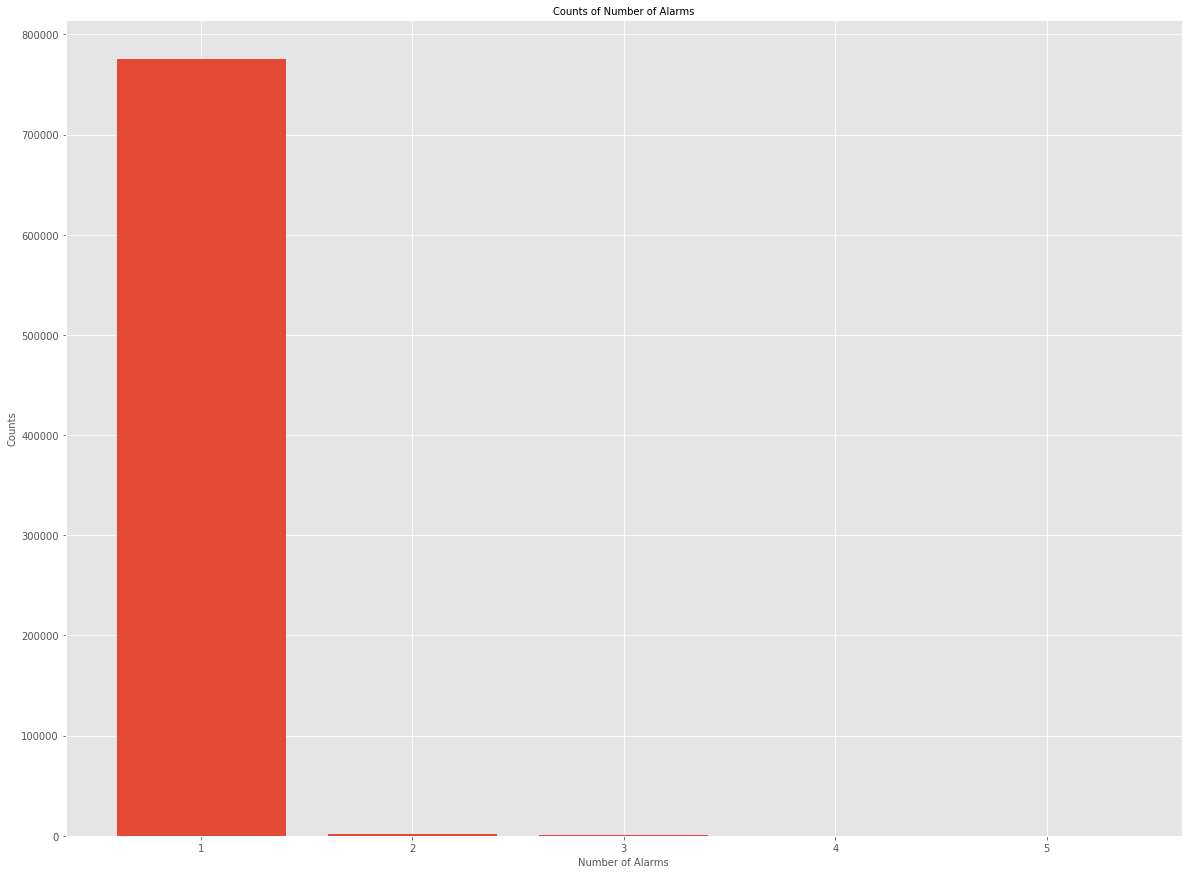

In [108]:
plot_bar_graph(df,'Number of Alarms')

In [109]:
#not meaningful, drop columns
df.drop(labels='Number of Alarms',axis=1, inplace = True)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778045 entries, 0 to 1091289
Data columns (total 11 columns):
Call Type                               778045 non-null object
Received DtTm                           778045 non-null datetime64[ns]
Original Priority                       774872 non-null object
ALS Unit                                778045 non-null bool
Call Type Group                         388306 non-null object
Unit Type                               778045 non-null object
Unit sequence in call dispatch          778038 non-null float64
Neighborhooods - Analysis Boundaries    778045 non-null object
call_to_disp                            778045 non-null float64
disp_to_resp                            778045 non-null float64
resp_to_scene                           778045 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(4), object(5)
memory usage: 86.0+ MB


### Investigate Unit Type

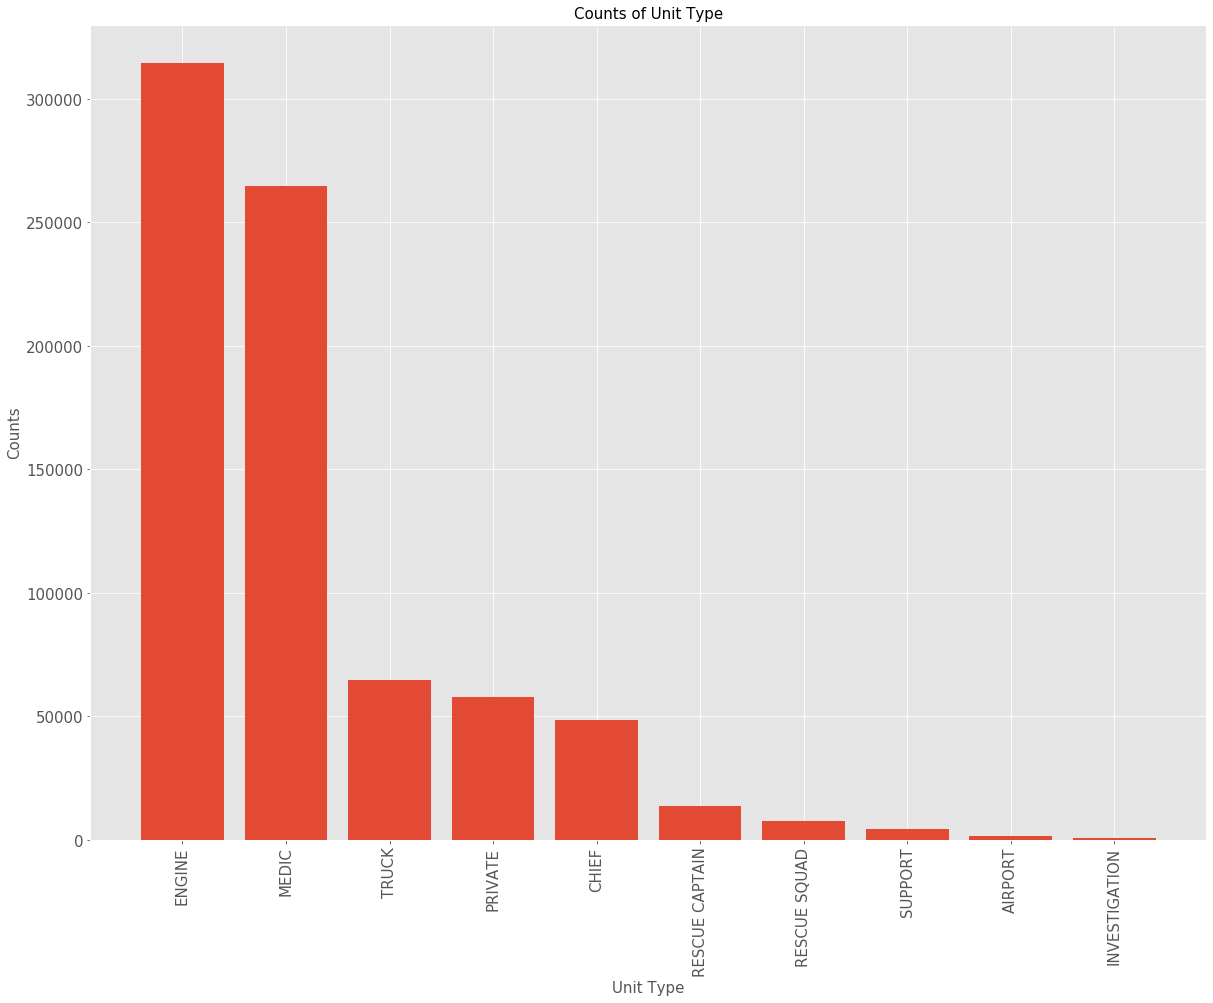

In [111]:
plot_bar_graph(df, 'Unit Type',font_size=15, tick_size=15 )

In [112]:
#will keep these

### Investigate Neighborhooods - Analysis Boundaries

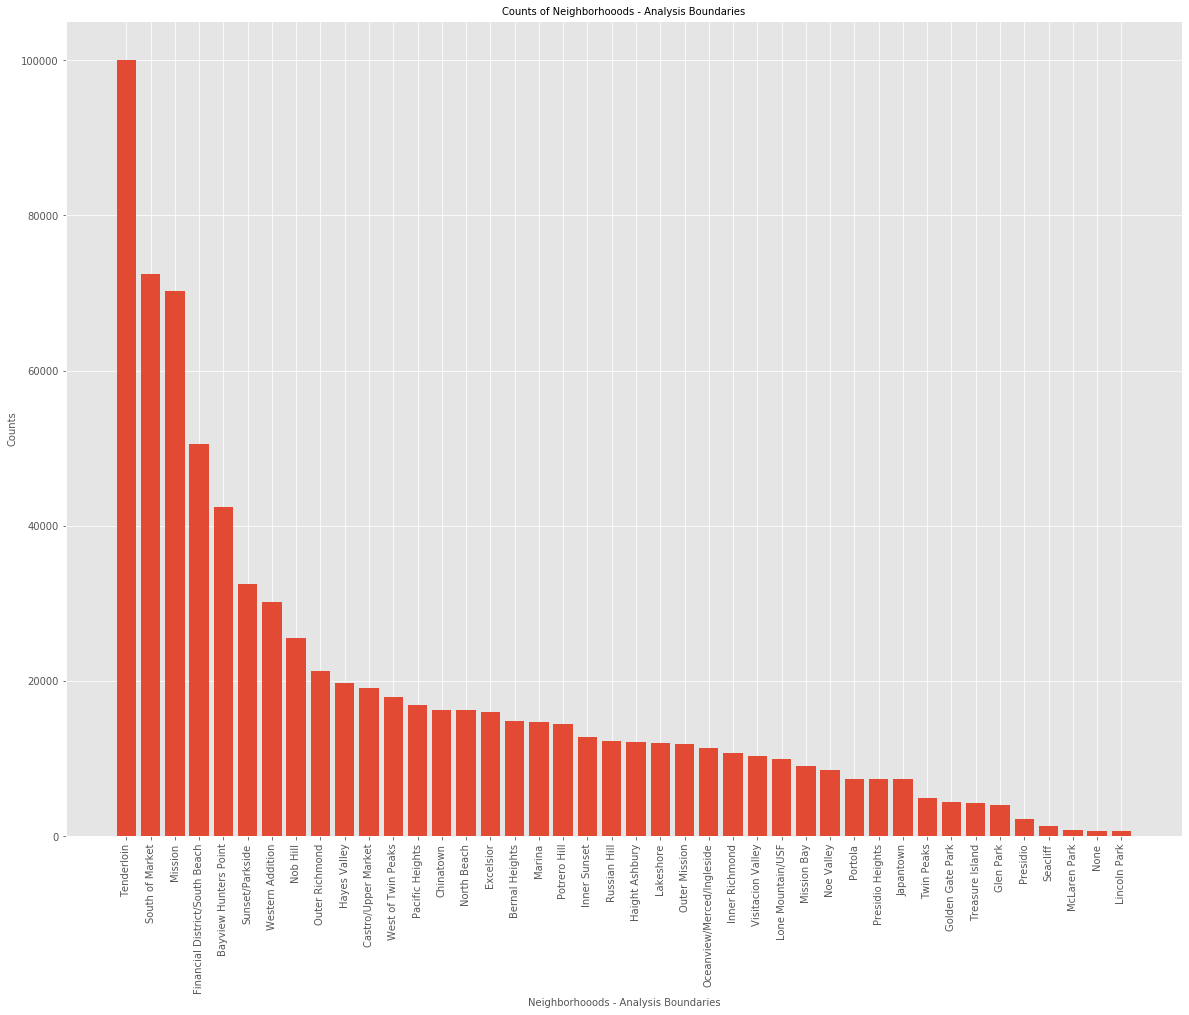

In [113]:
plot_bar_graph(df,'Neighborhooods - Analysis Boundaries')

In [114]:
#can keep all of these

### Investigate Call Type Group

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778045 entries, 0 to 1091289
Data columns (total 11 columns):
Call Type                               778045 non-null object
Received DtTm                           778045 non-null datetime64[ns]
Original Priority                       774872 non-null object
ALS Unit                                778045 non-null bool
Call Type Group                         388306 non-null object
Unit Type                               778045 non-null object
Unit sequence in call dispatch          778038 non-null float64
Neighborhooods - Analysis Boundaries    778045 non-null object
call_to_disp                            778045 non-null float64
disp_to_resp                            778045 non-null float64
resp_to_scene                           778045 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(4), object(5)
memory usage: 86.0+ MB


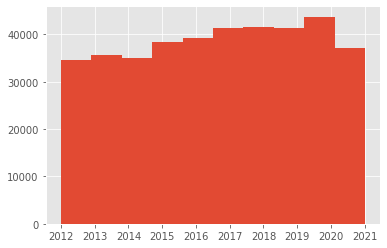

In [116]:
df['Received DtTm'][~df['Call Type Group'].isnull()].hist()

In [117]:
#still too sparse to use
df.drop(labels = 'Call Type Group', axis=1, inplace = True)

## Delete any final rows with null

In [118]:
#code to check what proportion of rows have at least 1 null
(len(df)-(sum((~df.isna()).all(axis=1))))/len(df)

0.004078170285780385

In [119]:
#code to include only rows with no null values
df = df[(~df.isnull()).all(axis=1)]
len(df)

774872

### Do some feature engineering on date

In [120]:
df['Received DtTm'][0].dayofweek

1

In [121]:
#get year from date
#There is a steady trend in the increase in calls, so I will leave year as numeric column
df['Call Year'] = df['Received DtTm'].apply(lambda x: x.year)

In [122]:
#get month from date
#There is seasonality in months, so will need to dummify
df['Call Month'] = df['Received DtTm'].apply(lambda x: x.month)

In [123]:
#get dayofweek from date
#There is seasonality in months, so will need to dummify
df['Call DoW'] = df['Received DtTm'].apply(lambda x: x.dayofweek)

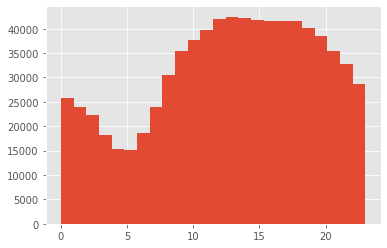

In [124]:
df['Received DtTm'].apply(lambda x: x.hour).hist(bins=24)

In [125]:
#want to capture 0-2,3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23


In [126]:
#get time of day in 3 hour increments
df['Call ToD'] = df['Received DtTm'].apply(lambda x: int(x.hour/3))

In [127]:
df['Call ToD'].value_counts()

4    126551
5    124944
6    120055
3    112936
7     96836
2     73055
0     71813
1     48682
Name: Call ToD, dtype: int64

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774872 entries, 0 to 1091289
Data columns (total 14 columns):
Call Type                               774872 non-null object
Received DtTm                           774872 non-null datetime64[ns]
Original Priority                       774872 non-null object
ALS Unit                                774872 non-null bool
Unit Type                               774872 non-null object
Unit sequence in call dispatch          774872 non-null float64
Neighborhooods - Analysis Boundaries    774872 non-null object
call_to_disp                            774872 non-null float64
disp_to_resp                            774872 non-null float64
resp_to_scene                           774872 non-null float64
Call Year                               774872 non-null int64
Call Month                              774872 non-null int64
Call DoW                                774872 non-null int64
Call ToD                                774872 non-null int64


In [129]:
#can get rid of Call Number - can later use it for some feature engineering to see number of responses on a given call
df.drop(labels='Call Number', axis=1, inplace = True)

KeyError: "['Call Number'] not found in axis"

## Check correlations

In [130]:
import seaborn as sb

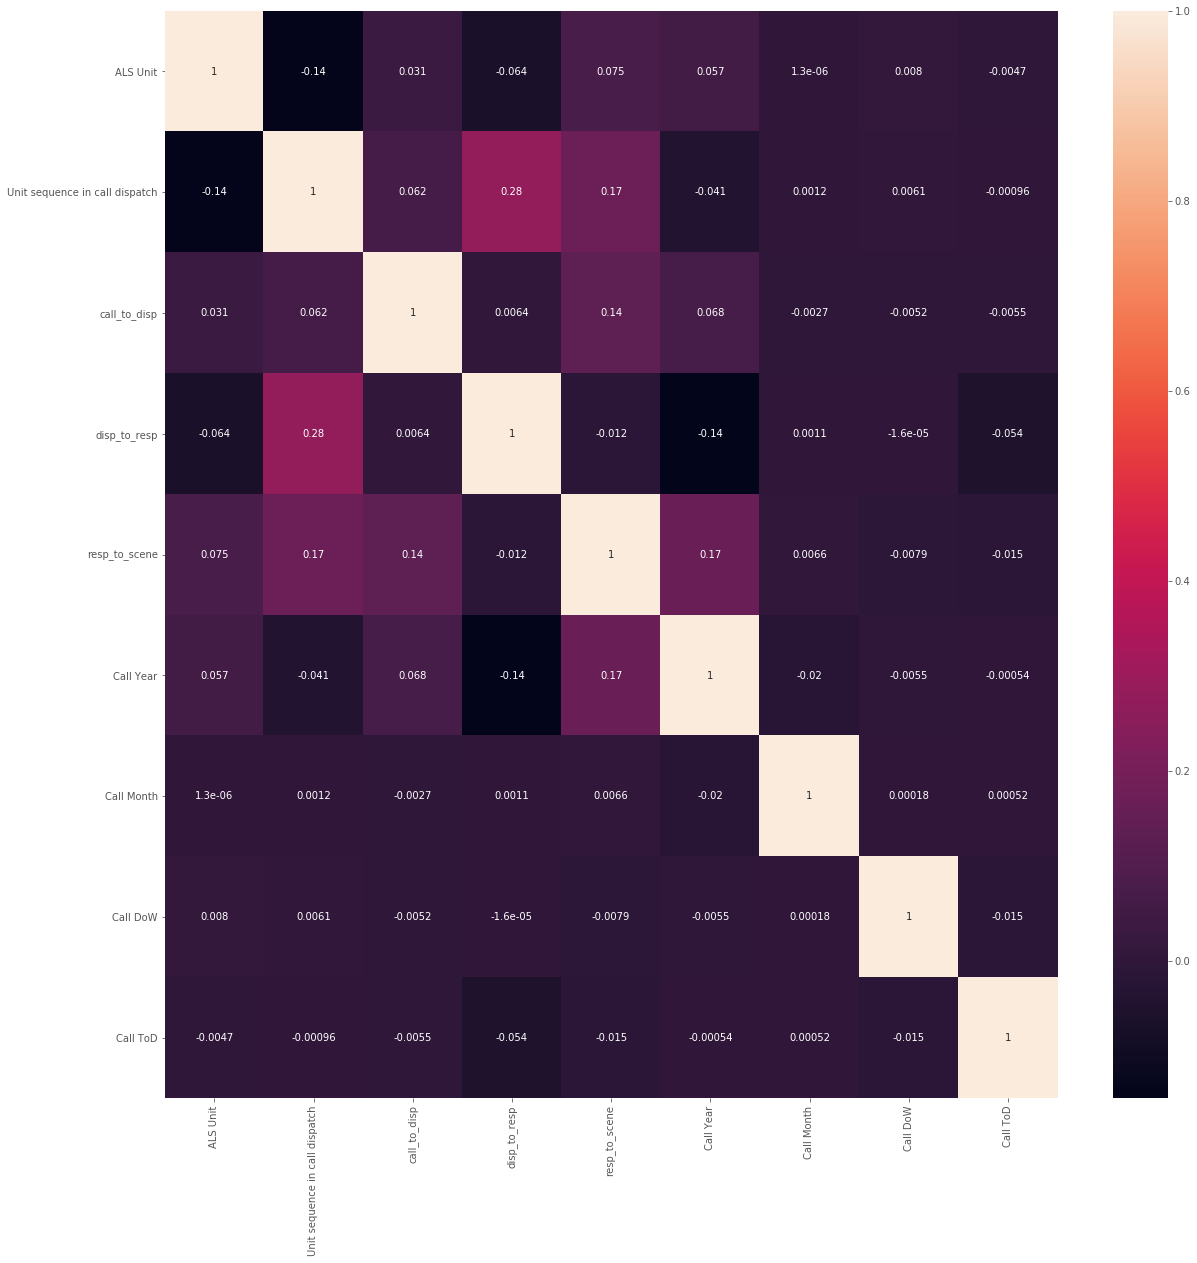

In [131]:
plt.figure(figsize = (20,20))
sb.heatmap(df.corr(), annot = True)

In [133]:
#convert from bool to int
df['ALS Unit'] = df['ALS Unit'].astype(int)

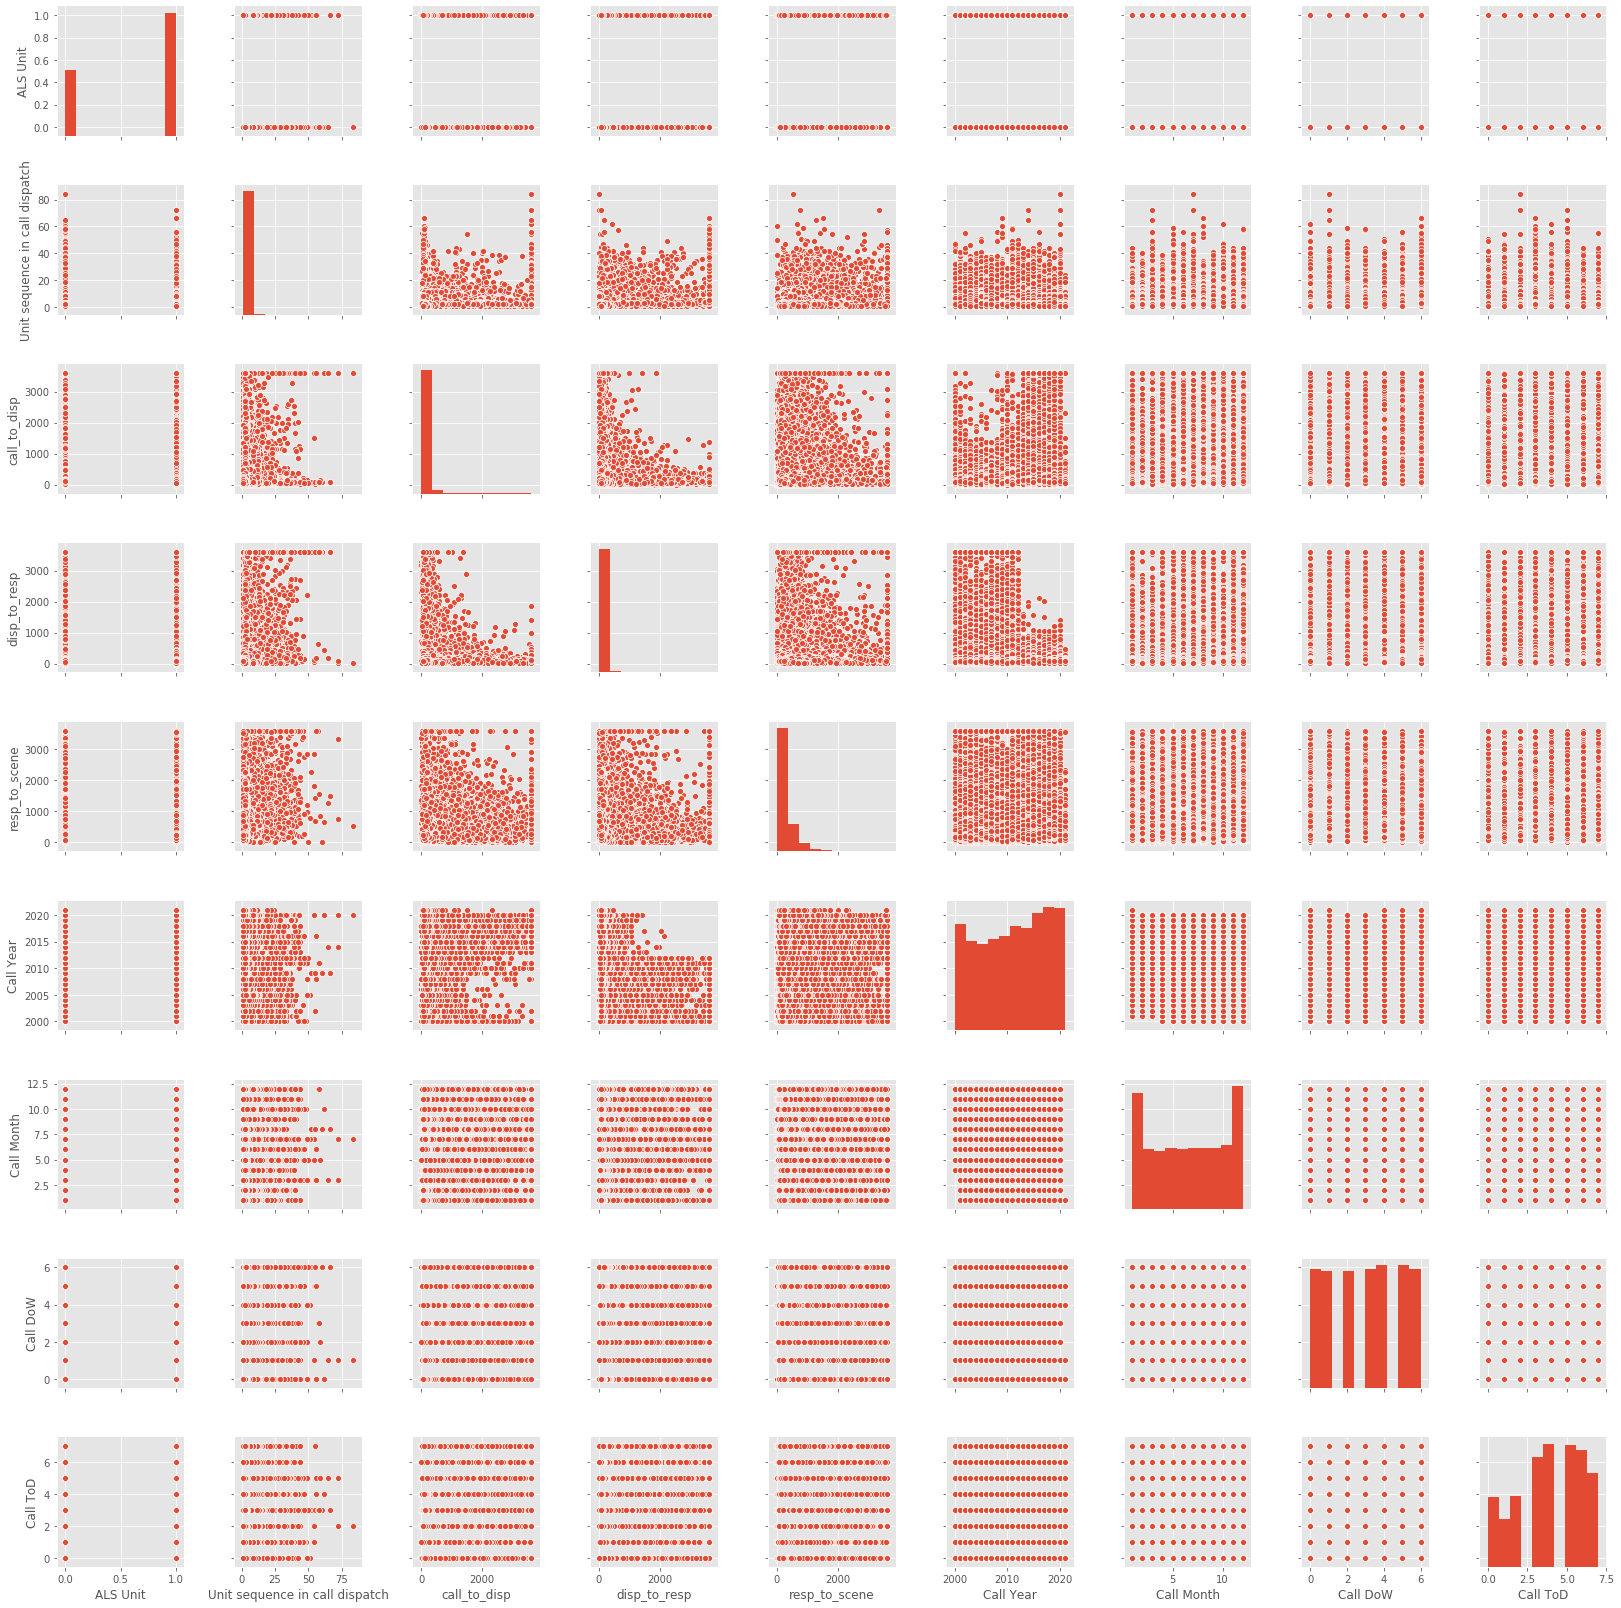

In [134]:
sb.pairplot(df)

In [ ]:
#not seeing any obvious correlations, but let's see!

### Save file as cleaned version to run model on

In [135]:
df.to_csv('20%_samp_cleaned.csv')

## Ideas

In [ ]:
#find number of calls within +/- 10 min range from call to estimate the surge at that time to use as feature
